In [1]:
'''
File : report.ipynb
Description : All analysis and interpretations for the ECON3203 Group Report
Author : Joel Maxwell 
zID : z5280733
'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

# === Load Data ===

raw_sample : pd.DataFrame = pd.read_csv("../Data/ATM_sample.csv")
raw_test : pd.DataFrame = pd.read_csv("../Data/ATM_test.csv")

## Data Description

- Shops: Number of shops/restaurants within walkable distance (in 100).
- ATMs: Number of other ATMs within a walkable distance (in 10).
- Downtown: Indicates whether the ATM is in downtown (1) or not (0).
- Weekday: Indicates whether the day is a weekday (1) or not (0).
- Center: Indicates whether the ATM is located in a center (1) or not (0).
- High: Indicates whether the ATM has a high cash demand in the last month (1) or not (0).
- Withdraw: The total cash withdrawn in a day (in 1000 local currency).

In [2]:
'''
Section : EDA 1
'''

null_count : int = raw_sample.isnull().sum()
descriptive_statistics : pd.DataFrame = raw_sample.describe()

print(f"\n === Null Count ===\n\n {null_count}\n")
print(f"\n === Descriptive Statistics ===\n\n {descriptive_statistics}\n")


 === Null Count ===

 Shops       0
ATMs        0
Downtown    0
Weekday     0
Center      0
High        0
Withdraw    0
dtype: int64


 === Descriptive Statistics ===

               Shops          ATMs     Downtown       Weekday        Center  \
count  22000.000000  22000.000000  22000.00000  22000.000000  22000.000000   
mean       7.316373      7.937455      0.70200      0.714091      0.102455   
std        4.118692      3.673415      0.45739      0.451857      0.303252   
min        0.800000      0.000000      0.00000      0.000000      0.000000   
25%        1.050000      4.000000      0.00000      0.000000      0.000000   
50%        9.890000      9.000000      1.00000      1.000000      0.000000   
75%       10.070000     11.000000      1.00000      1.000000      0.000000   
max       10.830000     17.000000      1.00000      1.000000      1.000000   

               High      Withdraw  
count  22000.000000  22000.000000  
mean       0.301591     54.652818  
std        0.458959

## Exploratory Data Analysis Part One

- There are 22,000 observations in the dataset with no missing values
- Shops has a mean of approximately 7.32, with a standard deviation of about 4.12
- ATMs averages around 7.94, with a standard deviation of 3.67.
- Downtown indicates that approximately 70% of the ATMs are located downtown.
- 71% of the records are from weekdays.
- 10% of the ATMs are located in a center.
- 30% of the ATMs had a high cash demand in the last month.
- Withdraw has a mean of approximately 54,653, with a standard deviation of 25,100.

Most ATMs in the dataset are located downtown and are accessed on weekdays. There is a higher density of both shops and other ATMs near the recorded ATMs. The average daily withdrawal amount is quite variable, suggesting there might be different customer behaviors or varying levels of foot traffic across these ATM locations.

/Users/joelmaxwell/miniconda3/envs/econ-unsw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


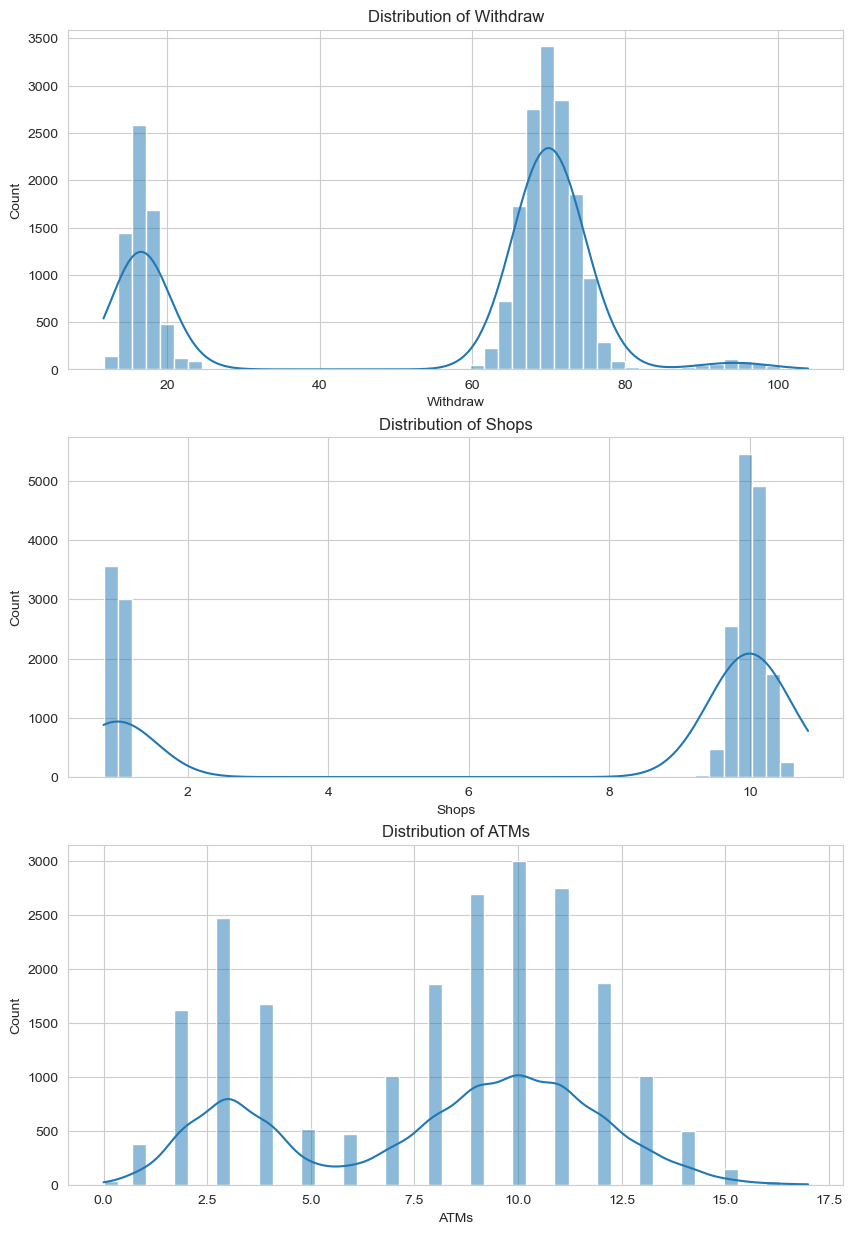

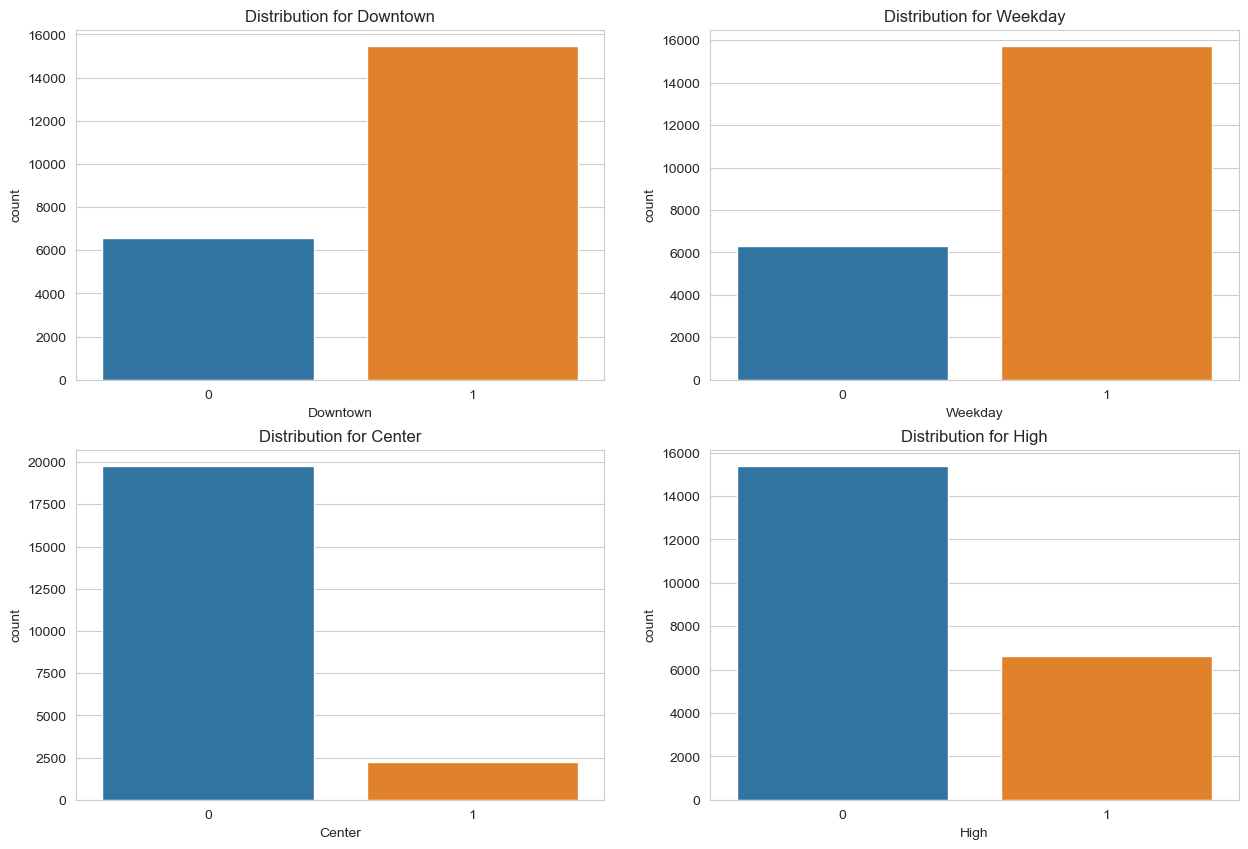

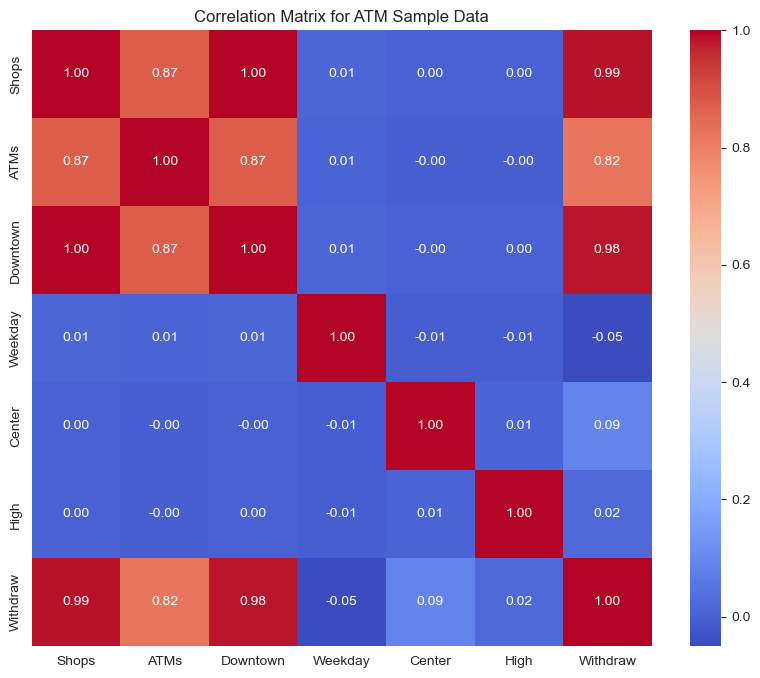

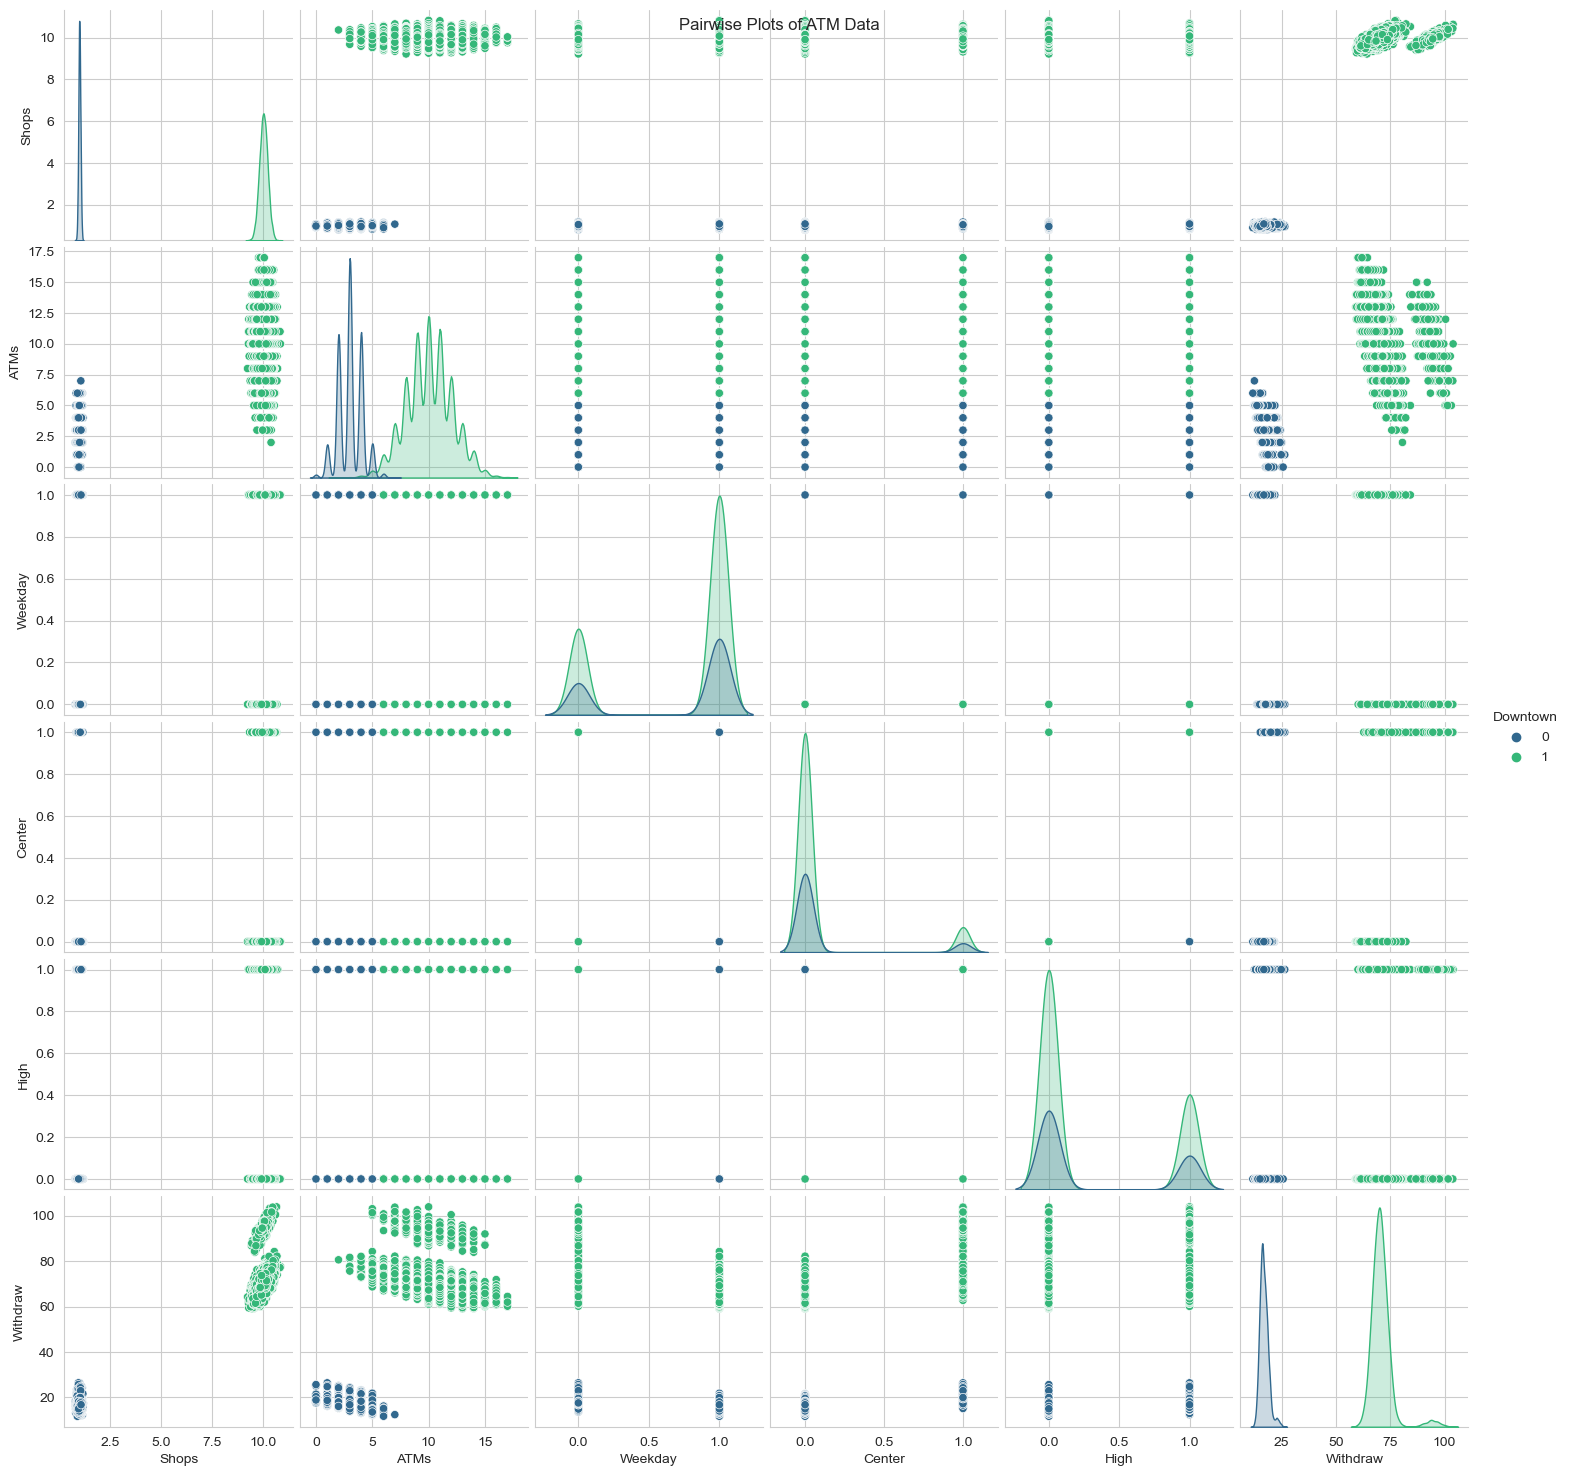

In [3]:
'''
Section : EDA 2
'''

sns.set_style("whitegrid")
numerical_variables : list[str] = ["Withdraw", "Shops", "ATMs"]
categorical_variables : list[str] = ["Downtown", "Weekday", "Center", "High"]

# === Numerical Distributions ===

_, num_axes = plt.subplots(3, 1, figsize=(10, 15))

for i, var in enumerate(numerical_variables) :

    sns.histplot(raw_sample[var], bins=50, kde=True, ax=num_axes[i])
    num_axes[i].set_title(f"Distribution of {var}")


# === Categorical Distributions ===

_, c_axes = plt.subplots(2, 2, figsize=(15,10))
cat_axes = [a for sublist in c_axes for a in sublist]

for i, var in enumerate(categorical_variables) :

    sns.countplot(x=var, data=raw_sample, ax=cat_axes[i])
    cat_axes[i].set_title(f"Distribution for {var}")


# === Correlation Matrix ===

corr_matrix : pd.DataFrame = raw_sample.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for ATM Sample Data')

# === Pairwise Plots ===

# NOTE: Since Withdrawals is highly correlated with the binary variable downtown, set the hue variable to be Downtown to search for groupings

pairwise_plot = sns.pairplot(raw_sample, kind='scatter', diag_kind='kde', hue="Downtown", palette='viridis')
pairwise_plot.fig.suptitle("Pairwise Plots of ATM Data")

plt.show()

## Exploratory Data Analysis Part Two

#### Distribution Summary

- Shops has a bimodal distribution -> Two groups of ATMs
- ATMs has a similar distribution to shops -> Two groups of ATMs
- More ATMs downtown than not
- Data collection is weighted towards weekdays
- Most ATMs did not have high cash demand last month
- Most ATMs are not in a center

#### Correlation Summary

- Withdraw is highly correlated with Shops, Downtown and ATMs
- Withdraw is more weakly correlated with Weekends, Center and High
- There is a high correlation between shops and downtown (Drop downtown as it has a lower correlation with Withdraw)
    > This correlation makes sense as intuitively there will be more shops downtown

#### Pairwise Summary

- Clear groupings in the data based on the downtown variable
- There also appears to be smaller groupings based on the weekday variable
- Looks to be a linear relationship between (Shops, ATMS) and Withdrawals

#### Story Behind the Data

ATMs tend to be located in downtown areas where the population is high, this corresponds to a greater number of shops and other ATMs nearby. Withdrawal amounts are higher on weekdays, which could be due to regular weekday transactions. However, the relationship between the number of nearby shops/ATMs and the withdrawal amount is not entirely linear, suggesting other factors might influence withdrawal behavior, such as the specific day of the week, events, or seasonal trends.

There might also be different clusters of ATMs. For example, those in high-density commercial areas and those in less commercial areas. These environments could cater to different customer behaviors which would be reflected by the withdrawal amount. This is made clear in the pairwise plot where the hue is based on the downtown variable. When plotting, it becomes apparent that there are two distinct groups.

In [4]:
'''
Split Data to Dependent and Independent and scale
'''

# === Split Data ===

numerical_variables.remove("Withdraw")

y_obs : pd.DataFrame = raw_sample['Withdraw']
x_obs : pd.DataFrame = raw_sample.drop('Withdraw', axis=1)

y_obs_test : pd.DataFrame = raw_test['Withdraw']
x_obs_test : pd.DataFrame = raw_test.drop('Withdraw', axis=1)

# === Scale the Data ===

std_scaler : StandardScaler = StandardScaler()
x_scaled : np.ndarray = std_scaler.fit_transform(x_obs[numerical_variables])
x_obs[numerical_variables] = x_scaled

x_scaled_test : np.ndarray = std_scaler.fit_transform(x_obs_test[numerical_variables])
x_obs_test[numerical_variables] = x_scaled_test

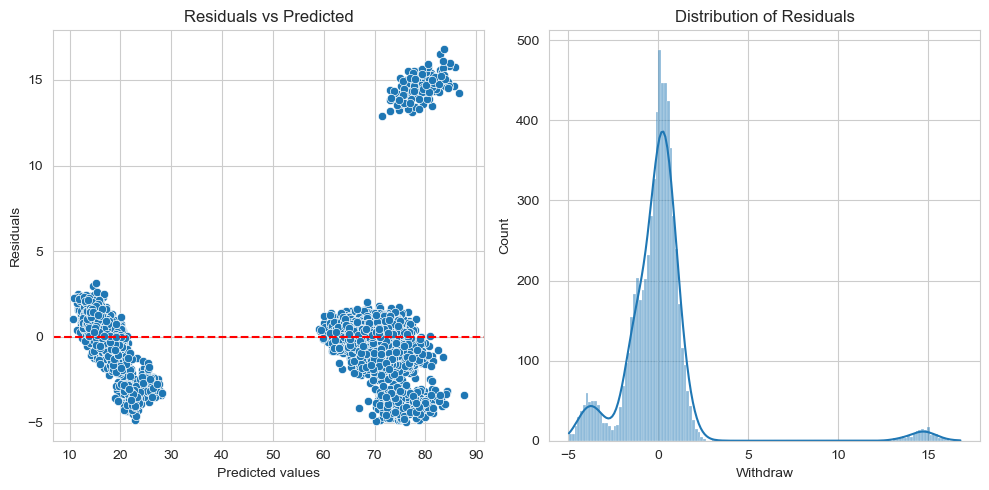

7.907951014410795


In [5]:
'''
Section : Model N - Standard Linear Regression
'''

# === Train a Standard Linear Model ===

X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.3, random_state=23)

linear_model : LinearRegression = LinearRegression()
linear_model.fit(X_train, y_train)

# === Assess a Standard Linear Model ===

y_pred : np.ndarray = linear_model.predict(X_test)
residuals : np.ndarray = y_test - y_pred

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
axs[0].set_title('Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# === MSE Against Test Data ===

y_pred_test : np.ndarray = linear_model.predict(x_obs_test)
mse_std_linear : float = mean_squared_error(y_pred_test, y_obs_test)
print(mse_std_linear)


## Model One Discussion

From the residual plots it is clear that there are two main groupings in the predicted values. This is to be expected as from before it was shown that Withdrawals follows a bimodal distribution. The bimodal distribution in EDA had peaks at around [15-17] and [70]. We can see this reflected in the Residuals vs Predicted plots where there is clear clustering around these values. It should also be noted that heteroscedasticity is present in our model as a result of these clusters.

However, there appears to be a second cluster at the top-end of the distribution where the residuals are quite high. This indicates that our model is not capturing some behaviours and there might me some distinct groups in our data that we are not accounting for.

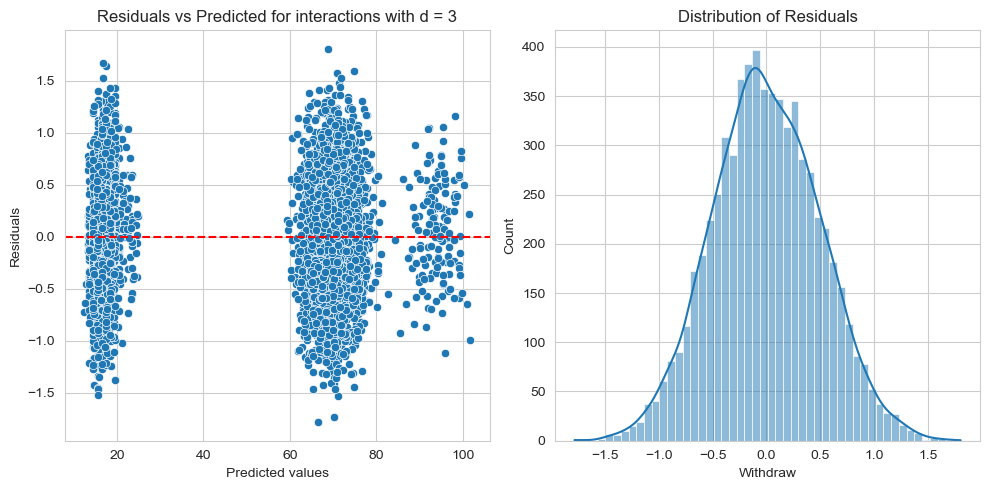

0.38002728991011886
[(15.87630105, 16.30966725873064), (70.8367198, 72.0493589717364), (67.73544612, 67.10379758738176), (73.68641976, 73.76998781239294), (74.52483004, 74.37965963809586), (16.66620268, 16.432209988588227), (69.0314439, 69.83815437599901), (18.93542033, 19.226619294728792), (68.74180285, 69.24002401121864), (73.99122714, 75.10119493822329), (15.13496453, 15.49220242002724), (16.04033131, 16.413017898143522), (75.7644249, 76.15754927997034), (70.17589406, 70.62374752095303), (15.22766312, 15.539204440269728), (17.32817766, 16.550030937292576), (69.08469228, 69.51923069824508), (18.95606158, 18.40995714503852), (69.69588482, 70.63067995533764), (67.7816325, 68.75277722125026), (15.5674031, 15.472315790212463), (20.31690035, 19.30858041884504), (76.38129991, 76.67717602734577), (69.72696805, 70.56936939307494), (66.06326729, 67.5979102464543), (61.75092607, 62.814863833264965), (73.95199252, 73.63717481587202), (65.02481683, 65.59072676989841), (17.28115928, 17.2911745092

In [22]:
'''
Section : Model N - Interaction Terms
'''

# === Find optimal degree for interaction terms ===

X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.3, random_state=23)

possible_degress : list[int] = [d for d in range(1, 6)]
mses : list[float] = []
models : list[Pipeline] = []

for d in possible_degress :

    pipeline : Pipeline = make_pipeline(PolynomialFeatures(degree=d), LinearRegression())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mses.append(mse)
    models.append(pipeline)

   
# === Analyse the optimal model ===

optimal_index : int = np.argmin(mses)
optimal_degree : int = possible_degress[optimal_index]
optimal_model : Pipeline = models[optimal_index]

y_pred : np.ndarray = optimal_model.predict(X_test)
residuals : np.ndarray = y_test - y_pred

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
axs[0].set_title(f'Residuals vs Predicted for interactions with d = {optimal_degree}')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# === Test Model against Test Data ===

y_pred_test : np.ndarray = optimal_model.predict(x_obs_test)
mse : float = mean_squared_error(y_pred_test, y_obs_test)
print(mse)
print([x for x in zip(y_obs_test, y_pred_test)])


In [7]:
'''
Section : Model 3 - Ridge Regression
'''

X_train, X_test, y_train, y_test = train_test_split(x_obs, y_obs, test_size=0.3, random_state=57)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge = Ridge(random_state=95)
ridge_cv = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

best_ridge_model = ridge_cv.best_estimator_

y_pred_ridge = best_ridge_model.predict(X_test)
ridge_test_error = mean_squared_error(y_test, y_pred_ridge)

'\nSection : Model 3 - Standard Ridge Regression\n'

In [8]:
'''
Section : Model 3 - Ridge Regression with Polynomial Features (Downtown Omitted)
'''

'\nSection : Model 3 - Ridge Regression with Polynomial Features (Downtown Omitted)\n'

In [9]:
'''
Section : Model 4 - Ridge Regression with Downtown Interaction Terms
'''

'\nSection : Model 4 - Ridge Regression with Downtown Interaction Terms\n'

In [10]:
'''
Section : Model 5 - Ridge Regression with Downtown and Polynomial Interaction Terms
'''

'\nSection : Model 5 - Ridge Regression with Downtown and Polynomial Interaction Terms\n'

## Discussion
Todo

## Resources

https://developer.nvidia.com/blog/a-comprehensive-guide-to-interaction-terms-in-linear-regression/#:~:text=An%20important%2C%20and%20often%20forgotten,value%20of%20another%20independent%20variable.

https://online.stat.psu.edu/stat462/node/120/#:~:text=The%20Answer%3A%20The%20residuals%20depart,regression%20function%20is%20not%20linear.